# Correlations in simulation
## Testing the assumption of Poisson processes

In [1]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)

# Import specific moduls
#import network_params; reload(network_params)
import model_class; reload(model_class)
import sim_params as sim; reload(sim)
%matplotlib inline

show_fig = False
save_fig = True
picture_format = ".pdf"
xfactor = 2.6
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
plotting = True

In [2]:
# DATA
data_file = "micro"
data_sup_path = "/export/data-schuessler/data_microcircuit/"
data_path = os.path.join(data_sup_path, data_file)
sim_spec = "a1.0_t300.2_totalN_00"

# Original data
file_name  = sim_spec + ".hdf5"  
res_file_name = sim_spec + "_res.hdf5"

### Basic data

In [3]:
# Open file: data
data_file = h5py.File(os.path.join(data_path, file_name), "r")

# Simulation attributes
area    = data_file.attrs["area"]   
t_sim   = data_file.attrs["t_sim"]  
t_trans = data_file.attrs["t_trans"]
dt      = data_file.attrs["dt"]    
populations   = data_file.attrs["populations"].astype("|U4")
layers        = data_file.attrs["layers"].astype("|U4")        
types         = data_file.attrs["types"].astype("|U4")     
n_populations = data_file.attrs["n_populations"]
n_layers      = data_file.attrs["n_layers"]       
n_types       = data_file.attrs["n_types"] 

t_measure = t_sim - t_trans


# labels & colors: need to be adapted if n_types != (e, i)
layer_colors = style.colors[:n_layers]
colors = np.array([color for color in layer_colors for i in range(n_types)])
colors[1::2] = colors[1::2] * 0.4   #### adapt for more than two types!
if reverse_order:
    populations = populations[::-1]
    layers = layers[::-1]
    types = types[::-1]
    colors = colors[::-1]
data_file.close()

# Spike-train correlation 

In [20]:
# choose population(s)
i = 0 # population
population = populations[i]
# correlation between neuron j and k of population i
js = [0, 1]

# Data
with h5py.File(os.path.join(data_path, file_name), "r") as data_file:
    grp = data_file[sim_spec2 + "/spikes"]
    subgrp = grp[str(population)]
    raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
    indices         = subgrp["rec_neuron_i"][:]

# Histogram parameters
bin_width = 0.005 # s
n_bins = int(t_measure/ bin_width)

bins_ac = np.arange(bin_width, t_measure, bin_width)
acs = np.zeros((n_populations, n_bins-1))
bins_cc = np.arange(-t_measure, t_measure, bin_width)
ccs = np.zeros((n_populations, n_bins * 2 -1))

hist_times = np.zeros((2, n_bins))
for k, j in enumerate(js):
    times = raw_times_all[indices[j]:indices[j+1]]
    times = times[times > t_trans]
    
    hist_times[k] = (np.histogram(times, bins=n_bins, range=(0, t_measure), density=True)[0])
    
acs[i]     = np.correlate(hist_times[0], hist_times[0], mode="full")[n_bins:]
ccs[i]     = np.correlate(hist_times[0], hist_times[1], mode="full")

### Autocorrelation

save figure to autocorrelation_a1.0_t300.2_totalN_00_L6i_L6i.pdf


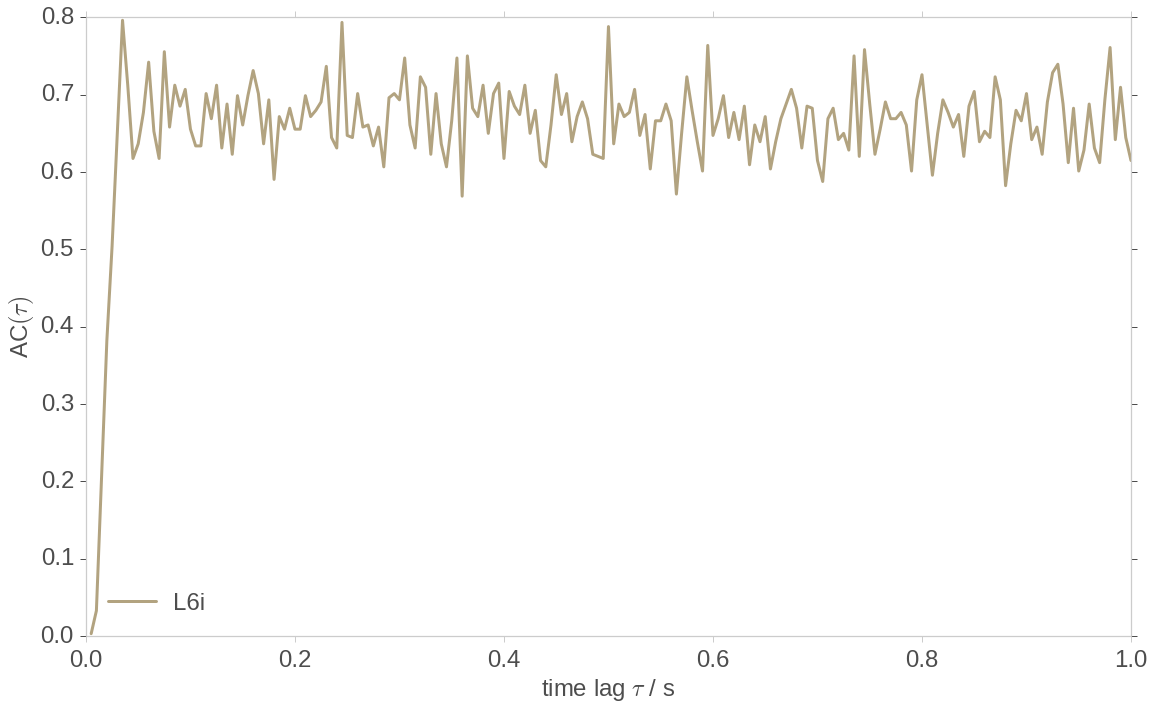

In [21]:
max_t = 1.0 # s
bins_red = bins_ac[bins_ac<= max_t]
ac_red  = acs[i][bins_ac<= max_t]

fig = plt.figure()
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

# Histograms
ax1.plot(bins_red, ac_red, "-",
     linewidth=3., color=colors[i], alpha=0.5, label=population)

# Histogram
ax1.set_ylabel('AC$(\\tau)$')
ax1.set_xlabel('time lag $\\tau$ / s')
ax1.set_xlim(0, max_t)
#ax1.set_ylim(0, 100)
ax1.grid(False)
ax1.legend(loc=0)
    
for ax in fig.axes:
    style.fixticks(ax)
fig_name = "autocorrelation_" + sim_spec + "_" + population

fig_name += "_" + population
fig_name += picture_format

if save_fig:
    print("save figure to " + fig_name)
    fig.savefig(os.path.join(figure_path,fig_name))
else:
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + sim_spec
    fig.suptitle(suptitle, y=0.98)

if show_fig:
    fig.show()

### Spike train cross correlations

save figure to correlation_a1.0_t300.2_totalN_00_L6i_L6i.pdf


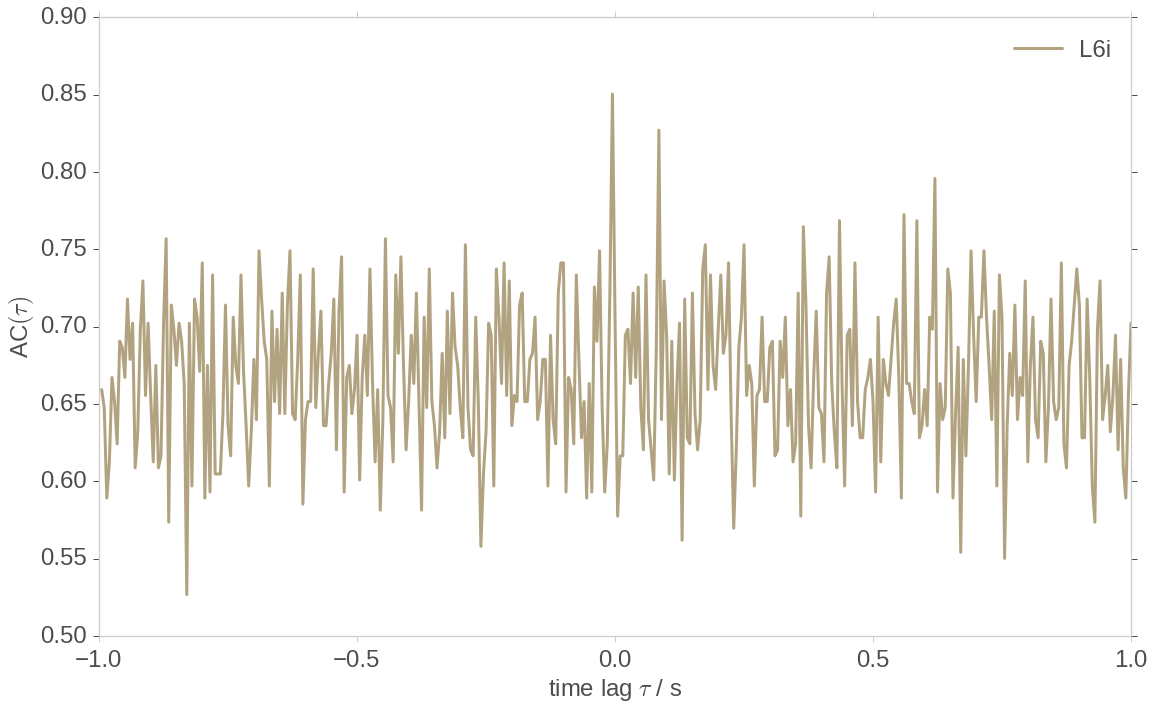

In [22]:
max_t = 1. # s
bins_red = bins_cc[abs(bins_cc)<= max_t]
cc_red  = ccs[i][abs(bins_cc)<= max_t]

fig = plt.figure()
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)

# Histograms
ax1.plot(bins_red, cc_red, "-",
     linewidth=3., color=colors[i], alpha=0.5, label=population)

# Histogram
ax1.set_ylabel('AC$(\\tau)$')
ax1.set_xlabel('time lag $\\tau$ / s')
ax1.set_xlim(-max_t, max_t)
#ax1.set_ylim(0, 100)
ax1.grid(False)
ax1.legend(loc=0)
    
for ax in fig.axes:
    style.fixticks(ax)
fig_name = "correlation_" + sim_spec + "_" + population

fig_name += "_" + population
fig_name += picture_format

if save_fig:
    print("save figure to " + fig_name)
    fig.savefig(os.path.join(figure_path,fig_name))
else:
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + sim_spec
    fig.suptitle(suptitle, y=0.98)

if show_fig:
    fig.show()